In [161]:
# Import necessary libraries
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from pathlib import Path
import zipfile

In [162]:
import pandas as pd
from pathlib import Path

# Definisikan path ke file CSV
csv_file_path = Path("/content/ALLFLOWMETER_HIKARI2021.csv")

# Pastikan file CSV ada
if csv_file_path.is_file():
    print("Loading ALLFLOWMETER_HIKARI2021 data...")
    data = pd.read_csv(csv_file_path)
    print("Data loaded successfully.")
else:
    print(f"The file {csv_file_path} does not exist.")

data = pd.read_csv("/content/ALLFLOWMETER_HIKARI2021.csv")


Loading ALLFLOWMETER_HIKARI2021 data...
Data loaded successfully.


In [163]:
# Identify columns that are of object type (likely strings in your dataset)
categorical_cols = data.select_dtypes(include=['object']).columns

# Apply Label Encoding to each categorical column
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

In [164]:
flow_features = [
    'flow_duration',        'fwd_pkts_tot',        'bwd_pkts_tot',        'fwd_data_pkts_tot',   'bwd_data_pkts_tot',
    'fwd_pkts_per_sec',    'bwd_pkts_per_sec',    'flow_pkts_per_sec',   'down_up_ratio',        'fwd_header_size_tot',
    'fwd_header_size_min',  'fwd_header_size_max',  'bwd_header_size_tot',  'bwd_header_size_min',  'bwd_header_size_max',
    'flow_FIN_flag_count',  'flow_SYN_flag_count',  'flow_RST_flag_count',  'fwd_PSH_flag_count',   'bwd_PSH_flag_count',
    'fwd_iat.min',         'fwd_iat.max',         'fwd_iat.avg',         'fwd_iat.std',         'bwd_iat.min',
    'bwd_iat.max',         'bwd_iat.avg',         'bwd_iat.std',         'active.min',          'active.max',
    'active.tot',         'active.avg',          'active.std',          'idle.min',           'idle.max',
    'idle.tot',           'idle.avg',           'idle.std',           'traffic_category',   'fwd_subflow_pkts',
    'bwd_subflow_pkts',    'fwd_subflow_bytes',   'bwd_subflow_bytes',   'fwd_bulk_bytes',  'bwd_bulk_bytes',
    'fwd_bulk_packets',     'bwd_bulk_packets',    'fwd_bulk_rate',      'bwd_bulk_rate'
]

X = data[flow_features]
y = data["Label"]

X[:1], y[:1]

(   flow_duration  fwd_pkts_tot  bwd_pkts_tot  fwd_data_pkts_tot  \
 0       2.207588            15            14                  6   
 
    bwd_data_pkts_tot  fwd_pkts_per_sec  bwd_pkts_per_sec  flow_pkts_per_sec  \
 0                  6          6.794746          6.341763          13.136509   
 
    down_up_ratio  fwd_header_size_tot  ...  fwd_subflow_pkts  \
 0       0.933333                  464  ...               7.5   
 
    bwd_subflow_pkts  fwd_subflow_bytes  bwd_subflow_bytes  fwd_bulk_bytes  \
 0               7.0              913.0             2512.5             0.0   
 
    bwd_bulk_bytes  fwd_bulk_packets  bwd_bulk_packets  fwd_bulk_rate  \
 0             0.0               0.0               0.0            0.0   
 
    bwd_bulk_rate  
 0            0.0  
 
 [1 rows x 49 columns],
 0    1
 Name: Label, dtype: int64)

In [165]:
X = torch.from_numpy(np.asarray(X)).type(torch.float)
y = torch.from_numpy(np.asarray(y)).type(torch.float)

X[:1], y[:1]

(tensor([[2.2076e+00, 1.5000e+01, 1.4000e+01, 6.0000e+00, 6.0000e+00, 6.7947e+00,
          6.3418e+00, 1.3137e+01, 9.3333e-01, 4.6400e+02, 2.0000e+01, 4.0000e+01,
          4.9200e+02, 3.2000e+01, 4.4000e+01, 2.0000e+00, 2.0000e+00, 2.0000e+00,
          6.0000e+00, 5.0000e+00, 1.8120e+01, 1.9638e+06, 1.5769e+05, 5.2051e+05,
          7.8678e+00, 2.0329e+06, 1.6753e+05, 5.6063e+05, 2.2076e+06, 2.2076e+06,
          2.2076e+06, 2.2076e+06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 3.0000e+00, 7.5000e+00, 7.0000e+00, 9.1300e+02,
          2.5125e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 tensor([1.]))

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3, # 20% test, 80% train
                                                    random_state=41) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(388694, 166584, 388694, 166584)

In [167]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data (X_train)
# Note: We use .numpy() to convert the tensor back to numpy for fitting the scaler
X_train = X_train.numpy()
X_test = X_test.numpy()

# Fit the scaler and transform the training data
X_train = scaler.fit_transform(X_train)

# Transform the test data (using the same scaler fitted on the training data)
X_test = scaler.transform(X_test)

X_train = torch.from_numpy(X_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)

X[:2], y[:2]

(tensor([[2.2076e+00, 1.5000e+01, 1.4000e+01, 6.0000e+00, 6.0000e+00, 6.7947e+00,
          6.3418e+00, 1.3137e+01, 9.3333e-01, 4.6400e+02, 2.0000e+01, 4.0000e+01,
          4.9200e+02, 3.2000e+01, 4.4000e+01, 2.0000e+00, 2.0000e+00, 2.0000e+00,
          6.0000e+00, 5.0000e+00, 1.8120e+01, 1.9638e+06, 1.5769e+05, 5.2051e+05,
          7.8678e+00, 2.0329e+06, 1.6753e+05, 5.6063e+05, 2.2076e+06, 2.2076e+06,
          2.2076e+06, 2.2076e+06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 3.0000e+00, 7.5000e+00, 7.0000e+00, 9.1300e+02,
          2.5125e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.5624e+01, 1.5000e+01, 1.4000e+01, 6.0000e+00, 6.0000e+00, 9.6004e-01,
          8.9604e-01, 1.8561e+00, 9.3333e-01, 4.8800e+02, 2.0000e+01, 4.4000e+01,
          4.6800e+02, 3.2000e+01, 4.4000e+01, 2.0000e+00, 2.0000e+00, 2.0000e+00,
          6.0000e+00, 5.0000e+00, 2.0981e+01, 1.5343e+07, 1.1160e+06, 4.094

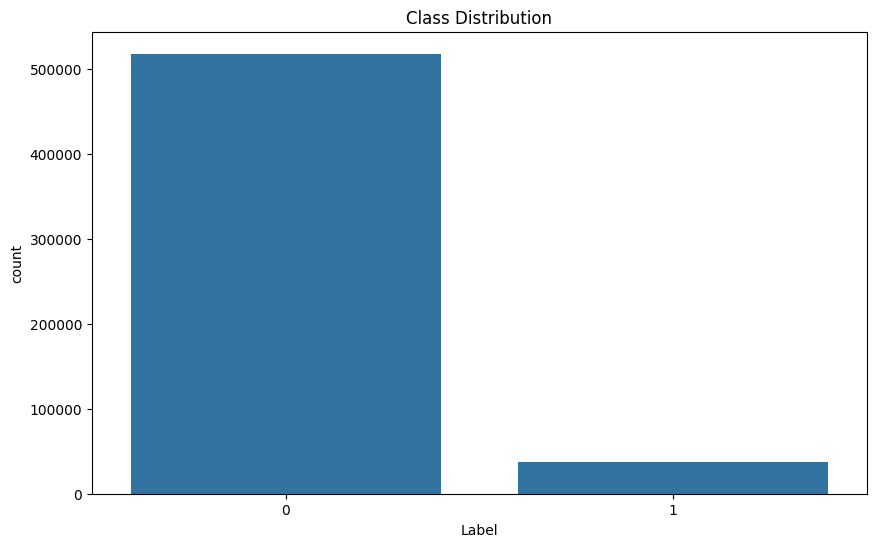

Label
0    93.211328
1     6.788672
Name: proportion, dtype: float64


In [168]:
# Cek Imbalance Kelas
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=data)
plt.title('Class Distribution')
plt.show()

# Tampilkan persentase kelas
class_counts = data['Label'].value_counts(normalize=True) * 100
print(class_counts)

In [169]:
from torch import nn

class Security(nn.Module):
    def __init__(self, input_size):
        super(Security, self).__init__()
        # Definisi lapisan dalam urutan yang lebih modular
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),   # Input -> Hidden Layer 1
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 256),          # Hidden Layer 1 -> Hidden Layer 2
            nn.Dropout(0.5),

            nn.Linear(256, 128),          # Hidden Layer 2 -> Hidden Layer 3
            nn.Dropout(0.5),

            nn.Linear(128, 1)             # Hidden Layer 3 -> Output Layer
        )

    def forward(self, x):
        # Melakukan forward propagation
        return self.layers(x)

# Inisialisasi model
input_size = 49
model = Security(input_size)
print(model)


Security(
  (layers): Sequential(
    (0): Linear(in_features=49, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [170]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.001,
                            weight_decay=1e-4)

In [171]:
import torch

# Fungsi umum untuk menghitung True Positives, False Positives, dan False Negatives
def compute_metrics(y_true, y_pred):
    """Helper function to compute true positives, false positives, and false negatives."""
    true_positive = torch.sum((y_true == 1) & (y_pred == 1)).float()
    false_positive = torch.sum((y_true == 0) & (y_pred == 1)).float()
    false_negative = torch.sum((y_true == 1) & (y_pred == 0)).float()
    true_negative = torch.sum((y_true == 0) & (y_pred == 0)).float()

    return true_positive, false_positive, false_negative, true_negative

# Fungsi Akurasi
def accuracy_fn(y_true, y_pred):
    """Calculate accuracy."""
    correct = torch.sum(y_true == y_pred).item()
    acc = (correct / len(y_true)) * 100
    return acc

# Fungsi Precision
def precision_fn(y_true, y_pred):
    """Calculate precision."""
    true_positive, false_positive, _, _ = compute_metrics(y_true, y_pred)
    precision = true_positive / (true_positive + false_positive + 1e-7)
    return precision.item()

# Fungsi Recall
def recall_fn(y_true, y_pred):
    """Calculate recall."""
    true_positive, _, false_negative, _ = compute_metrics(y_true, y_pred)
    recall = true_positive / (true_positive + false_negative + 1e-7)
    return recall.item()

# Fungsi F1 Score
def f1_score_fn(y_true, y_pred):
    """Calculate F1 score."""
    precision = precision_fn(y_true, y_pred)
    recall = recall_fn(y_true, y_pred)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
    return f1_score


In [172]:
# Function to train the model
def train_model(model, optimizer, loss_fn, X_train, y_train):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  # Apply sigmoid for binary classification

    # Calculate loss and metrics
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    precision = precision_fn(y_train, y_pred)
    recall = recall_fn(y_train, y_pred)
    f1 = f1_score_fn(y_train, y_pred)

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    return loss.item(), acc, precision, recall, f1

# Function to evaluate the model
def evaluate_model(model, loss_fn, X_test, y_test):
    model.eval()
    with torch.no_grad():
        # Forward pass
        y_logits = model(X_test).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        # Calculate loss and metrics
        loss = loss_fn(y_logits, y_test)
        acc = accuracy_fn(y_test, y_pred)
        precision = precision_fn(y_test, y_pred)
        recall = recall_fn(y_test, y_pred)
        f1 = f1_score_fn(y_test, y_pred)

    return loss.item(), acc, precision, recall, f1

# Fit the model
torch.manual_seed(41)
epochs = 40

for epoch in range(epochs):
    # Training step
    train_loss, train_acc, train_prec, train_recall, train_f1 = train_model(
        model, optimizer, loss_fn, X_train, y_train
    )

    # Testing step
    test_loss, test_acc, test_prec, test_recall, test_f1 = evaluate_model(
        model, loss_fn, X_test, y_test
    )

    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch}:")
        print(f"Train | Loss: {train_loss:.5f}, Acc: {train_acc:.2f}%, Precision: {train_prec:.2f}, Recall: {train_recall:.2f}, F1: {train_f1:.2f}")
        print(f"Test  | Loss: {test_loss:.5f}, Acc: {test_acc:.2f}%, Precision: {test_prec:.2f}, Recall: {test_recall:.2f}, F1: {test_f1:.2f}")
        print("---------------------------------------------------------------------------------------------")


Epoch 0:
Train | Loss: 0.66854, Acc: 68.42%, Precision: 0.06, Recall: 0.23, F1: 0.09
Test  | Loss: 0.57398, Acc: 93.21%, Precision: 0.00, Recall: 0.00, F1: 0.00
---------------------------------------------------------------------------------------------
Epoch 10:
Train | Loss: 0.20906, Acc: 93.21%, Precision: 0.00, Recall: 0.00, F1: 0.00
Test  | Loss: 0.18378, Acc: 93.21%, Precision: 0.00, Recall: 0.00, F1: 0.00
---------------------------------------------------------------------------------------------
Epoch 20:
Train | Loss: 0.08361, Acc: 98.18%, Precision: 0.92, Recall: 0.81, F1: 0.86
Test  | Loss: 0.05517, Acc: 98.90%, Precision: 0.97, Recall: 0.87, F1: 0.91
---------------------------------------------------------------------------------------------
Epoch 30:
Train | Loss: 0.03064, Acc: 98.97%, Precision: 0.99, Recall: 0.86, F1: 0.92
Test  | Loss: 0.01682, Acc: 98.88%, Precision: 1.00, Recall: 0.84, F1: 0.91
-----------------------------------------------------------------------

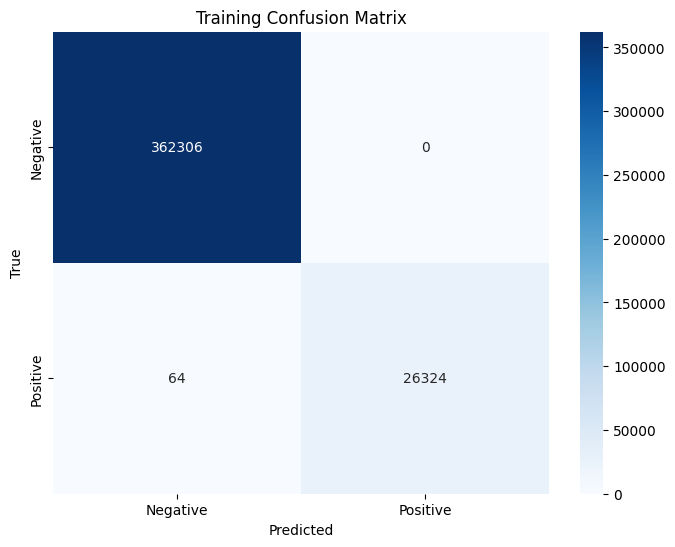

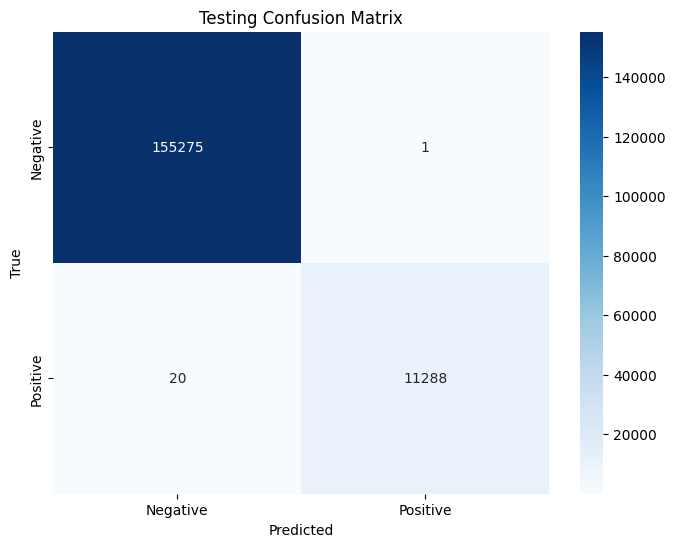

In [173]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Plot confusion matrix for training data
model.eval()
with torch.inference_mode():
    train_logits = model(X_train).squeeze()
    train_pred = torch.round(torch.sigmoid(train_logits))
    plot_confusion_matrix(y_true=y_train, y_pred=train_pred, title="Training Confusion Matrix")

# Plot confusion matrix for testing data
with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    plot_confusion_matrix(y_true=y_test, y_pred=test_pred, title="Testing Confusion Matrix")

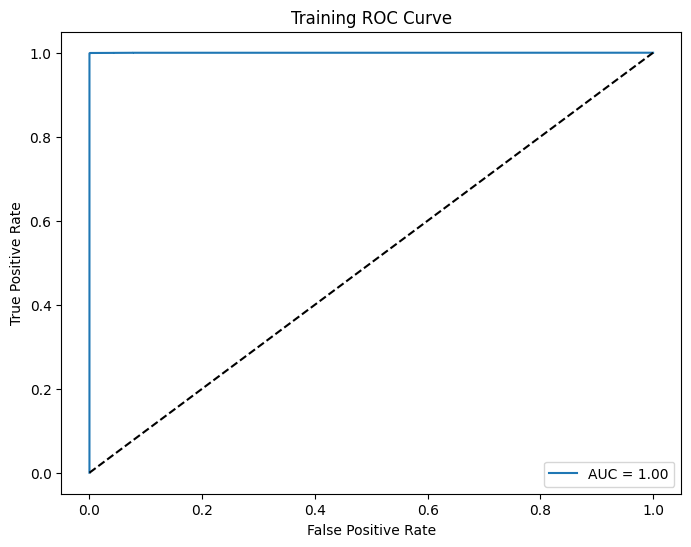

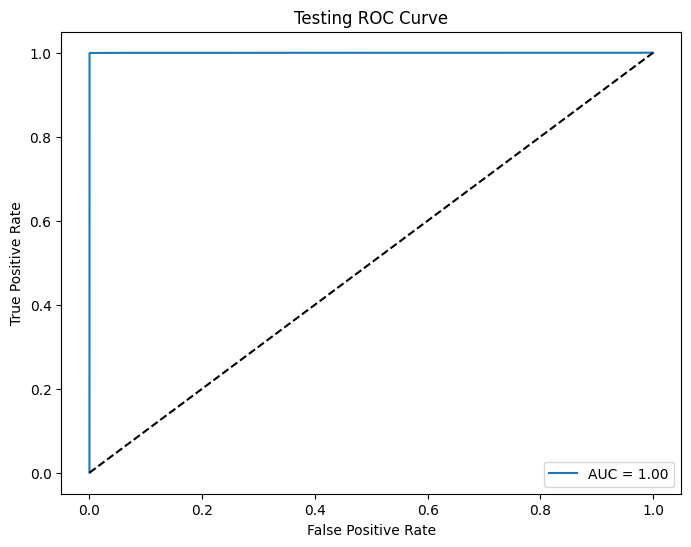

In [174]:
def plot_roc_auc(y_true, y_logits, title):
    fpr, tpr, _ = roc_curve(y_true.cpu(), torch.sigmoid(y_logits).cpu())
    auc = roc_auc_score(y_true.cpu(), torch.sigmoid(y_logits).cpu())
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

with torch.inference_mode():
    train_logits = model(X_train).squeeze()
    test_logits = model(X_test).squeeze()

plot_roc_auc(y_train, train_logits, "Training ROC Curve")
plot_roc_auc(y_test, test_logits, "Testing ROC Curve")

In [175]:
# Ensure predictions are rounded (binary classification)
test_pred = torch.round(torch.sigmoid(test_logits))

# Convert tensors to CPU and numpy for compatibility with sklearn functions
y_train_np = y_train.cpu().numpy()
y_test_np = y_test.cpu().numpy()
train_pred_np = train_pred.cpu().numpy()
test_pred_np = test_pred.cpu().numpy()

# Generate classification reports
train_classification_report = classification_report(y_train_np, train_pred_np, target_names=['Negative', 'Positive'])
test_classification_report = classification_report(y_test_np, test_pred_np, target_names=['Negative', 'Positive'])

# Print classification reports
print("Training Classification Report:")
print(train_classification_report)
print("Testing Classification Report:")
print(test_classification_report)

Training Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00    362306
    Positive       1.00      1.00      1.00     26388

    accuracy                           1.00    388694
   macro avg       1.00      1.00      1.00    388694
weighted avg       1.00      1.00      1.00    388694

Testing Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00    155276
    Positive       1.00      1.00      1.00     11308

    accuracy                           1.00    166584
   macro avg       1.00      1.00      1.00    166584
weighted avg       1.00      1.00      1.00    166584

